In [29]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

image_list = os.listdir("test_images")
image_list = [f for f in image_list if f.endswith('.jpg') or f.endswith('.png')]

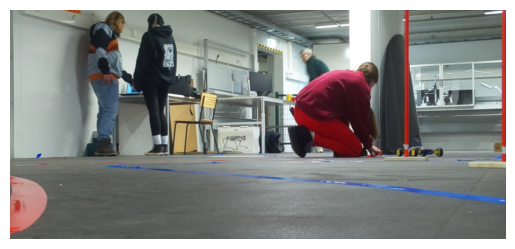

In [30]:
# open one image and plot it

test_image = cv2.imread(os.path.join("test_images", image_list[3]))
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [31]:
# PID coefficients
Kp = 0.1
Ki = 0.0
Kd = 0.05

# PID variables
previous_error = 0
integral = 0

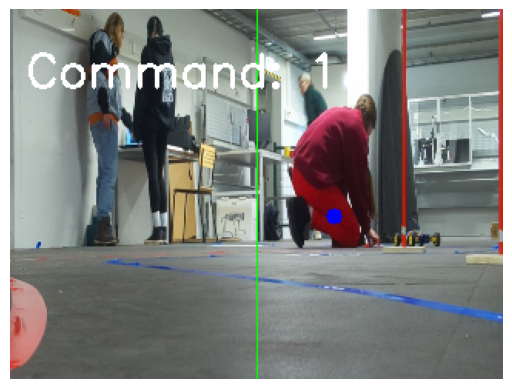

In [32]:
frame = cv2.resize(test_image, (320, 240))
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# Mask blue lane
lower_blue = np.array([100, 100, 50])
upper_blue = np.array([140, 255, 255])
mask = cv2.inRange(hsv, lower_blue, upper_blue)
mask[0:120, :] = 0 # Keep bottom half

contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

command = 3 # Default to STOP

if contours:
    largest = max(contours, key=cv2.contourArea)
    M = cv2.moments(largest)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        frame_center = frame.shape[1] // 2

        # Calculate PID error
        error = cx - frame_center
        integral += error
        derivative = error - previous_error
        output = Kp * error + Ki * integral + Kd * derivative
        previous_error = error

        # Draw visual indicators
        cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)
        cv2.line(frame, (frame_center, 0), (frame_center, frame.shape[0]), (0, 255, 0), 1)

        # Decide command based on PID output
        if abs(output) < 15:
            command = 1 # FORWARD
        elif output > 0:
            command = 4 # RIGHT
        else:
            command = 5 # LEFT

        cv2.putText(frame, f"Command: {command}", (10, 50),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        plt.imshow(frame)
        plt.axis('off')
        plt.show()

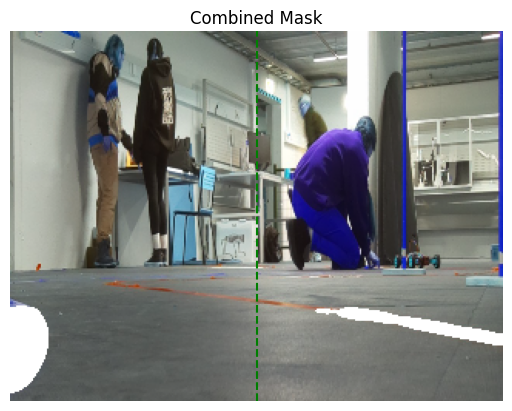

In [ ]:
frame = cv2.resize(test_image, (320, 240))

cutoff = 120 # Cutoff for bottom half of the image

# Mask blue lane
lower_blue = np.array([0, 0, 150])
upper_blue = np.array([150, 150, 255])
blue_mask = cv2.inRange(frame, lower_blue, upper_blue)
blue_mask[0:cutoff, :] = 0 # Keep bottom half

# Mask red lane
lower_red = np.array([160, 0, 0])
upper_red = np.array([255, 170, 170])
red_mask = cv2.inRange(frame, lower_red, upper_red)
red_mask[0:cutoff, :] = 0 # Keep bottom half

# Apply Gaussian blur to the mask
blurred_blue_mask = cv2.GaussianBlur(blue_mask, (15, 15), 0)
blurred_red_mask = cv2.GaussianBlur(red_mask, (15, 15), 0)

# Get image center line
height, width = frame.shape[:2]
image_center = width // 2

# Plot the image center line
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))



# Combine the masks and plot over the image
combined_mask = cv2.addWeighted(blurred_blue_mask, 1, blurred_red_mask, 1, 0)

# Apply the mask to frame
frame[combined_mask > 70] = [255, 255, 255]  # Change color of masked area to green
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axvline(x=image_center, color='g', linestyle='--', label='Image Center')
plt.title("Combined Mask")
plt.axis('off')
plt.show()

In [34]:
contours, _ = cv2.findContours(combined_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

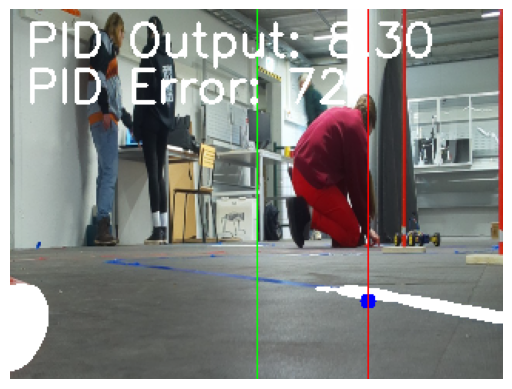

In [35]:
if contours:
    largest = max(contours, key=cv2.contourArea)
    M = cv2.moments(largest)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        frame_center = frame.shape[1] // 2
        # Calculate PID error
        error = cx - frame_center
        integral += error
        derivative = error - previous_error
        output = Kp * error + Ki * integral + Kd * derivative
        previous_error = error
        # Draw the center of the lane
        cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)
        cv2.line(frame, (frame_center, 0), (frame_center, frame.shape[0]), (0, 255, 0), 1)
        cv2.line(frame, (cx, 0), (cx, frame.shape[0]), (255, 0, 0), 1)
        # Draw PID output
        cv2.putText(frame, f"PID Output: {output:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        # Draw PID error
        cv2.putText(frame, f"PID Error: {error}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    else:
        print("No lane detected")

else:
    print("No contours found")

# Show the result
plt.imshow(frame)
plt.axis('off')
plt.show()